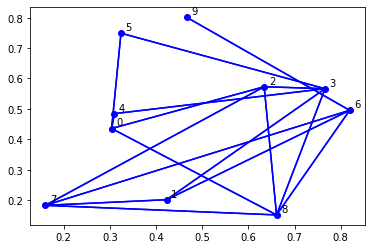

In [108]:
import numpy as np
import algos.graphdrawing as gd
      
V, adj_V = gd.gen_graph()
gd.draw(V, adj_V)

# Edge-Edge Repulsion (Lin & Yen, 2012)
Apply forces based on the angle formed by incident edges.

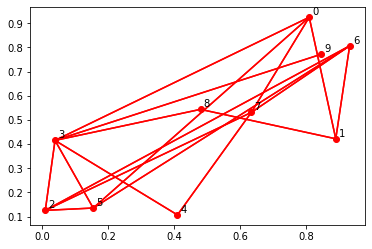

Angular resolution: 1.0059662221568084


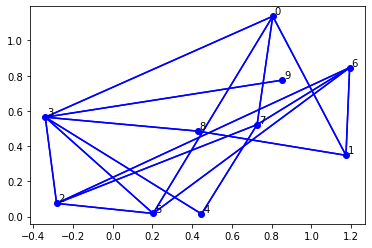

Angular resolution: 1.0751695136254829


In [50]:
import algos.lin_yen as ly
import algos.geometry as geo

gd.draw(V, adj_V, 'r')
print(f'Angular resolution: {geo.get_angular_res(V, adj_V)}')
W = ly.ee_repulsion(V, adj_V)
gd.draw(W, adj_V)
print(f'Angular resolution: {geo.get_angular_res(W, adj_V)}')


# Force-directed edge-vertex repulsion

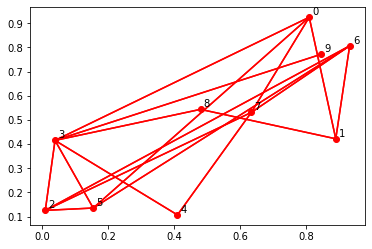

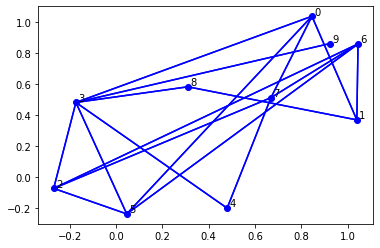

In [21]:
import numpy as np
import math

def is_left(p, q, r):
  # returns whether r is left of line pq
  s = (q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - [0])
  if s > 0:
    return True
  return False

def get_angle(v, w, u):
  '''
  Gets angle between vectors vu and vw.
  '''
  vu = np.subtract(u, v)
  vw = np.subtract(w, v)
  ret = np.arccos(np.dot(vu, vw) / (card(vu) * card(vw)))
  return ret
  
def ev_repulsion(V, adj_V, N=5, C1=1, C2=1, C3=1):
  W = V.copy()
  for a in range(N):
    F = np.subtract(V, W)
    F = np.multiply(C1, F)
    for i in range(len(V)):
      v = W[i]
      for j in range(len(V)):
        if i == j:
          continue
        w = W[j]
        for k in adj_V[j]:
          if i == k:
            continue
          u = W[k]
          vu = np.subtract(v, u)
          vw = np.subtract(v, w)
          vu_u = np.divide(vu, geo.card(vu))
          vw_u = np.divide(vw, geo.card(vw))
          bis = np.add(vu_u, vw_u)
          F_ang = np.divide(bis, geo.card(bis))
          uw = np.subtract(u, w)
          uw = np.divide(uw, 2)
          uwu = (w - v) + uw
          F_mag = C2 / geo.card(v - uwu)
          F[i] += (F_mag * F_ang)
    for i in range(len(V)):
      W[i] += np.multiply(C3, F[i])
  return W
      
gd.draw(V, adj_V, 'r')
W = ev_repulsion(V, adj_V, N=10, C1=1, C2=1, C3=0.001)
gd.draw(W, adj_V)

# Vertex-vertex repulsion (Birchfield & Overbye, 2018)

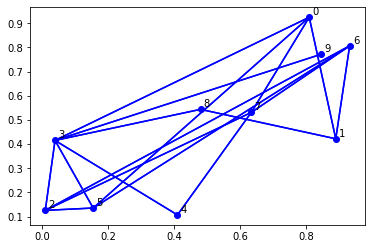

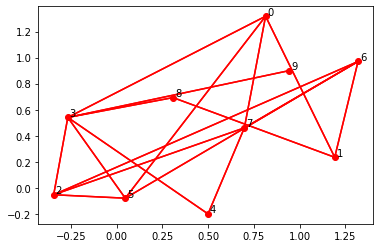

In [23]:
import algos.birchfield as bf
import algos
from importlib import reload

reload(algos.birchfield)
gd.draw(V, adj_V, 'b')
W = bf.force_directed(V, adj_V, N=10, C1=2, C2=0.1, C3=0.1)
gd.draw(W, adj_V, 'r')

# Frankenstein algorithm (Lin & Yen with Birchfield & Overbye)
Use the edge incident repulsion part of the algorithm from Lin & Yen and combine it with the part of the algorithm by Birchfield & Overbye where vertices are attracted to their initial positions.

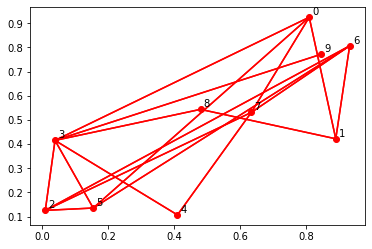

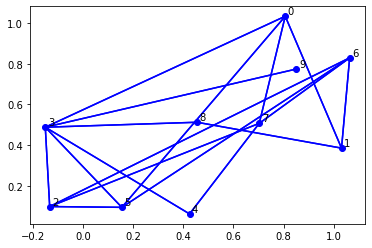

In [31]:
import algos.frankenstein as fs
import algos
from importlib import reload

reload(fs)
reload(algos)
gd.draw(V, adj_V, color='r')
W = fs.frankenstein(V, adj_V, N=5, C0=1, C6=0.005)
gd.draw(W, adj_V)

# Line intersections

[[0.5135598  0.26819835]
 [0.49783577 0.28070097]
 [0.3868057  0.36898411]
 [0.44911059 0.31944373]
 [0.50614501 0.5192451 ]
 [0.64726112 0.36731333]
 [0.73162154 0.42985109]
 [0.64295475 0.43503826]
 [0.60270501 0.39223177]
 [0.75319747 0.55228387]
 [0.73565201 0.56748565]
 [0.58722663 0.53382579]
 [0.63611421 0.54261712]
 [0.64441965 0.41200023]
 [0.73837389 0.45652493]
 [0.76092085 0.54559216]
 [0.71126366 0.58861627]
 [0.74231286 0.56171454]]


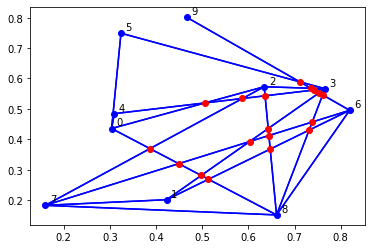

In [111]:
import matplotlib.pyplot as plt

ints, adj_ints = geo.get_intersects(V, adj_V)
gd.draw(V, adj_V)
plt.plot(ints[:,0], ints[:,1], 'ro')
plt.show()

# Used later for cross resolution maximization